In [52]:
import kymatio
import numpy as np
import random
import scipy.signal
import torch

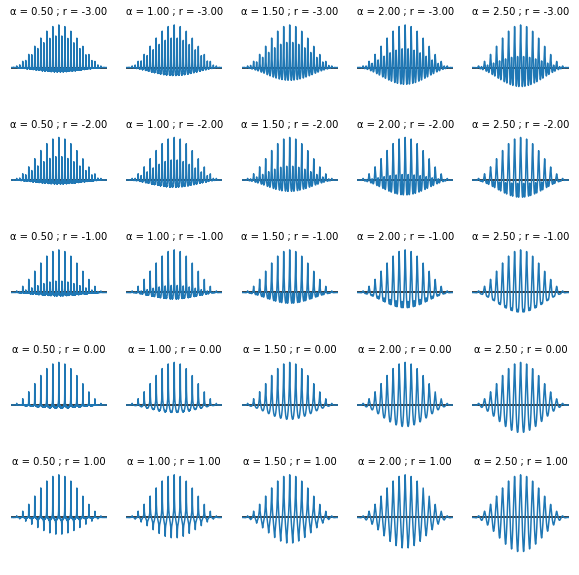

In [61]:
N = 2**10
f0 = 16

def generate(fourier_decay, odd_to_even, f0=16, N=2**10):
    if isinstance(f0, list):
        islist = True
        f0 = random.choice(f0)
    else:
        islist = False
    n_partials = int(N/(2*f0)) - 1
    t = np.linspace(0, 1, N, endpoint=False)
    partials = np.zeros((n_partials, N))
    for partial_id in range(n_partials):
        frequency = (1+partial_id) * f0
        if (partial_id % 2):
            amplitude = 1/(1+partial_id)**fourier_decay
        else:
            amplitude = odd_to_even/(1+partial_id)**fourier_decay
        partial = amplitude * np.cos(2*np.pi*frequency*t)
        partials[partial_id, :] = partial
    x = np.sum(partials, axis=0) * scipy.signal.hann(N)
    if islist:
        return (x / np.max(x), f0)
    else:
        return x / np.max(x)

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt



alphas = np.ravel(np.tile(np.array([0.5, 1.0, 1.5, 2.0, 2.5]), (1, 5)))
rs = np.ravel(np.tile(np.array([-3.0, -2.0, -1.0, 0.0, 1.0]), (5, 1)).T)
fig, axs = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()
 
for i in range(len(alphas)):
    a = alphas[i]
    r = rs[i]
    x = generate(a, 2**r, f0=f0, N=N)
    axs[i].plot(0*x, 'k')
    axs[i].plot(x)
    axs[i].set_xlim(0, N)
    axs[i].set_ylim(-1.1, 1.1)
    axs[i].set_title("α = {:.2f} ; r = {:.2f}".format(a, r), fontsize=10)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    #axs[i].set_xticks(np.linspace(0, N, 5))
    #axs[i].set_xticklabels(np.linspace(-0.5, 0.5, 5))
    axs[i].grid('on', linestyle='--', alpha=0.5)
    #axs[i].set_xlabel("Time")
    #axs[i].set_ylabel("Amplitude")

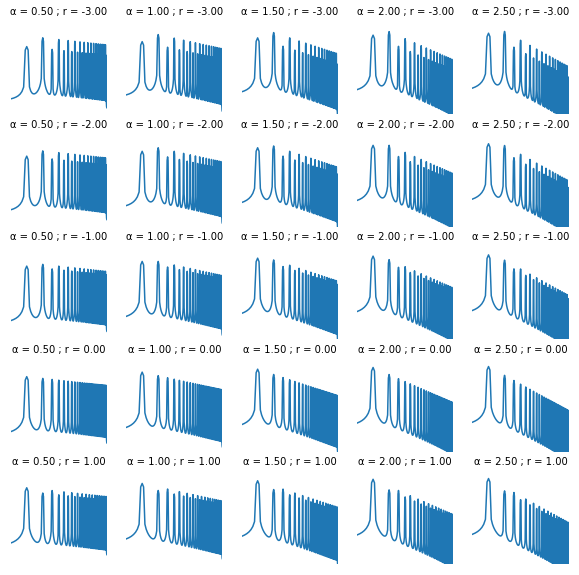

In [32]:
fig, axs = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(len(alphas)):
    a = alphas[i]
    r = rs[i]
    x = generate(a, 2**r, f0=f0, N=N)
    t = np.linspace(0, 1, N, endpoint=False)
    axs[i].plot(np.log2(N*t[1:(1+N//2)]), np.log10(np.abs(np.fft.rfft(x)))[1:])
    axs[i].set_ylim(-5, 3)
    axs[i].set_title("α = {:.2f} ; r = {:.2f}".format(a, r), fontsize=10)
    axs[i].set_xlim(3, 9)
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    #axs[i].set_xticks(range(3, 10))
    #axs[i].set_xticklabels(np.array(range(3, 10))-4)
    #axs[i].grid('on', linestyle='--', alpha=0.5)
    #axs[i].set_xlabel("Log-frequency")
    #axs[i].set_ylabel("Log-magnitude")

In [4]:

from ipywidgets import interactive
from IPython.display import Audio, display
import numpy as np

def render(fourier_decay, log2_odd_to_even):
    signal = generate(fourier_decay, 2**log2_odd_to_even, f0=256, N=2**15)
    rate = 22050
    display(Audio(data=signal, rate=rate, autoplay=True))
    return signal * 0.5
    
v = interactive(render, fourier_decay=(0.0,4.0), log2_odd_to_even=(-3.0, 1.0))
display(v)

interactive(children=(FloatSlider(value=2.0, description='fourier_decay', max=4.0), FloatSlider(value=-1.0, de…

In [36]:
# GENERATE SYNTHETIC DATA

import tqdm
from sklearn.preprocessing import StandardScaler
n_alpha = 50
n_r = 50

min_alpha = 0.0
max_alpha = 4.0
min_r = -3.0
max_r = 1.0

r_range = np.linspace(min_r, max_r, n_r, endpoint=True)
alpha_range = np.linspace(min_alpha, max_alpha, n_alpha, endpoint=True)
N = 2**10
X = np.zeros((n_r, n_alpha, N))
for i, r in tqdm.tqdm(enumerate(r_range)):
    for j, a in enumerate(alpha_range):
        X[i, j, :] = generate(a, 2**r, f0=16, N=N)
#moments = StandardScaler().fit_transform(moments)

50it [00:02, 23.01it/s]


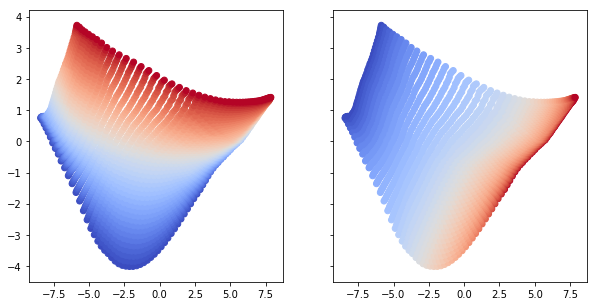

In [38]:
# ISOMAP ON RAW WAVEFORM

from sklearn.manifold import Isomap

n_components = 2
n_neighbors = 10
raw_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
Xmat = X.reshape((n_r*n_alpha, N))
raw_iso = raw_isomap.fit_transform(Xmat)
raw_isoReshape = raw_iso.reshape((n_r, n_alpha, n_components))

alpha_tiled = np.tile(alpha_range, (n_r, 1));
r_tiled = np.tile(r_range, (n_alpha, 1)).T;

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=True)
axs[0].scatter(
    np.ravel(raw_isoReshape[:, :, 0]),
    np.ravel(raw_isoReshape[:, :, 1]),
    c = np.ravel(r_tiled), cmap='coolwarm');
axs[1].scatter(
    np.ravel(raw_isoReshape[:, :, 0]),
    np.ravel(raw_isoReshape[:, :, 1]),
    c = np.ravel(alpha_tiled), cmap='coolwarm');

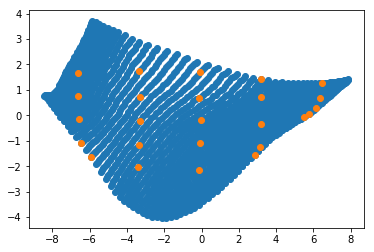

In [40]:
def find_landmarks(Y, n, m):
    xr = np.linspace(np.quantile(Y[:,0], q=0.1), np.quantile(Y[:,0], q=0.9), n)
    yr = np.linspace(np.quantile(Y[:,1], q=0.1), np.quantile(Y[:,1], q=0.9), m)
    xg, yg = np.meshgrid(xr, yr)
    
    idx = [0] * (n*m)
    for i, x, y in zip(range(n*m), xg.flatten(), yg.flatten()):
        idx[i] = int(np.sum(np.abs(Y-np.array([x,y]))**2, axis=-1).argmin())
    return idx

landmarks = find_landmarks(raw_iso, 5, 5)
plt.scatter(raw_iso[:,0], raw_iso[:,1])
plt.scatter(raw_iso[landmarks,0], raw_iso[landmarks,1])

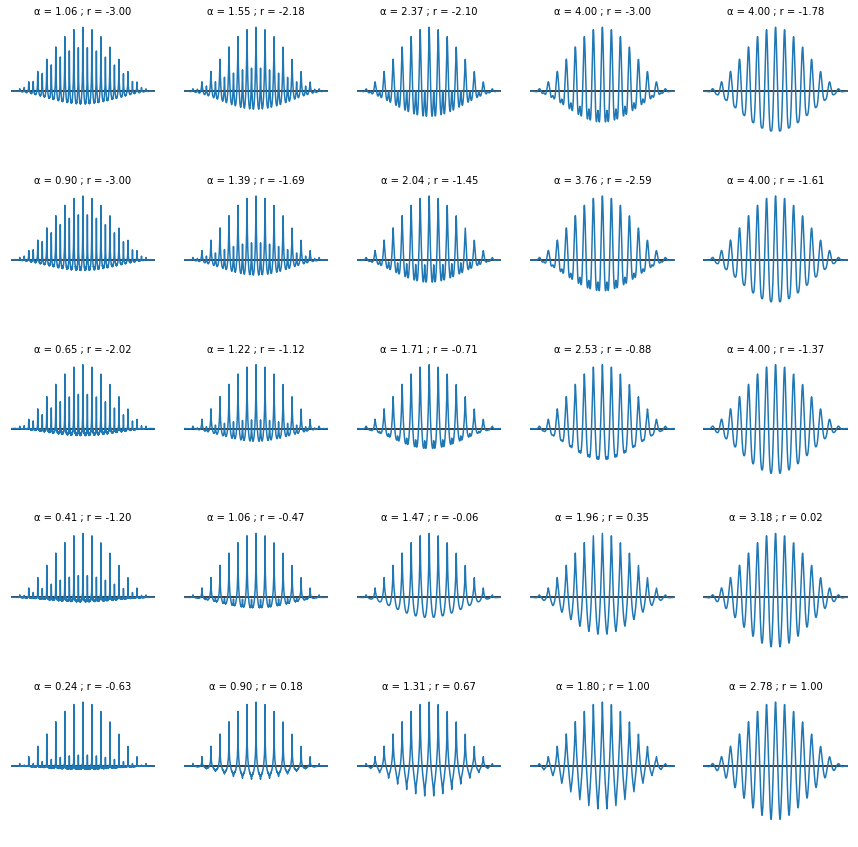

In [41]:
fig, axs = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axs = axs.flatten()

for i in range(len(landmarks)):
    x = Xmat[landmarks[i], :]
    a = alpha_range[landmarks[i] % n_r]
    r = r_range[landmarks[i] // n_alpha]
    axs[i].plot(0*x, 'k')
    axs[i].plot(x)
    axs[i].set_xlim(0, N)
    axs[i].set_ylim(-1.1, 1.1)
    axs[i].set_title("α = {:.2f} ; r = {:.2f}".format(a, r), fontsize=10)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)

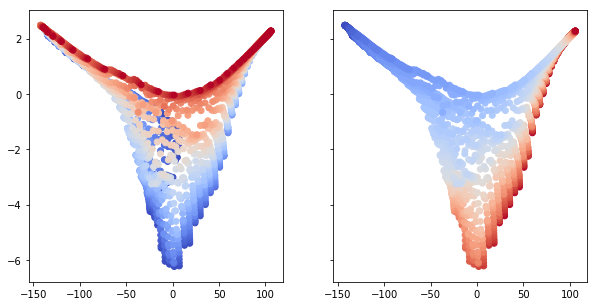

In [44]:
# ISOMAP ON SPECTRAL MOMENTS

Xhat = np.abs(np.fft.rfft(X, axis=-1))
centroids = np.mean(Xhat, axis=-1)
stddevs = np.std(Xhat, axis=-1)
skews = scipy.stats.skew(Xhat, axis=-1)
kurtoi = scipy.stats.kurtosis(Xhat, axis=-1)

moments = np.stack((centroids, stddevs, skews, kurtoi), axis=-1)
moments = moments.reshape(moments.shape[0]*moments.shape[1], moments.shape[2])

from sklearn.manifold import Isomap


moment_isomap = Isomap(n_neighbors=40, n_components=n_components)


moments_iso = moment_isomap.fit_transform(moments)
moments_iso = moments_iso.reshape((n_r, n_alpha, n_components))

alpha_tiled = np.tile(alpha_range, (n_r, 1));
r_tiled = np.tile(r_range, (n_alpha, 1)).T;

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=True)
axs[0].scatter(
    np.ravel(moments_iso[:, :, 0]),
    np.ravel(moments_iso[:, :, 1]),
    c = np.ravel(r_tiled), cmap='coolwarm');
axs[1].scatter(
    np.ravel(moments_iso[:, :, 0]),
    np.ravel(moments_iso[:, :, 1]),
    c = np.ravel(alpha_tiled), cmap='coolwarm');

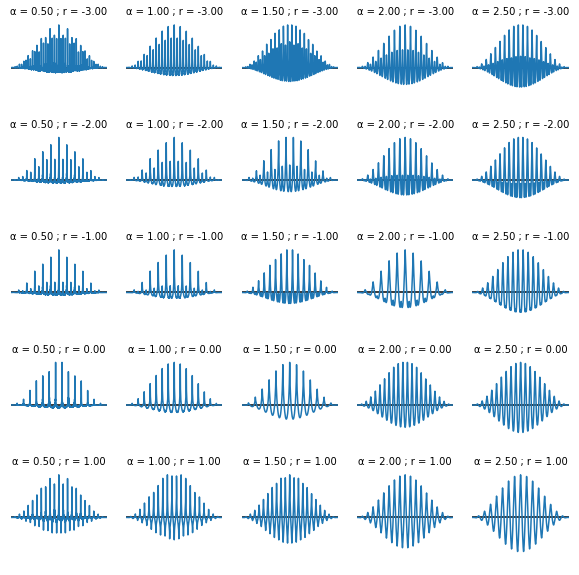

In [64]:
# EFFECT OF FUNDAMENTAL FREQUENCY

N = 2**10
f0 = 16

alphas = np.ravel(np.tile(np.array([0.5, 1.0, 1.5, 2.0, 2.5]), (1, 5)))
rs = np.ravel(np.tile(np.array([-3.0, -2.0, -1.0, 0.0, 1.0]), (5, 1)).T)
fig, axs = plt.subplots(5, 5, figsize=(10, 10), sharex=True, sharey=True)
axs = axs.flatten()
 
for i in range(len(alphas)):
    a = alphas[i]
    r = rs[i]
    x, f0 = generate(a, 2**r, f0=list(range(12, 24)), N=N)
    axs[i].plot(0*x, 'k')
    axs[i].plot(x)
    axs[i].set_xlim(0, N)
    axs[i].set_ylim(-1.1, 1.1)
    axs[i].set_title("α = {:.2f} ; r = {:.2f}".format(a, r), fontsize=10)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].spines["top"].set_visible(False)
    axs[i].spines["right"].set_visible(False)
    axs[i].spines["bottom"].set_visible(False)
    axs[i].spines["left"].set_visible(False)
    axs[i].grid('on', linestyle='--', alpha=0.5)

50it [00:02, 23.34it/s]


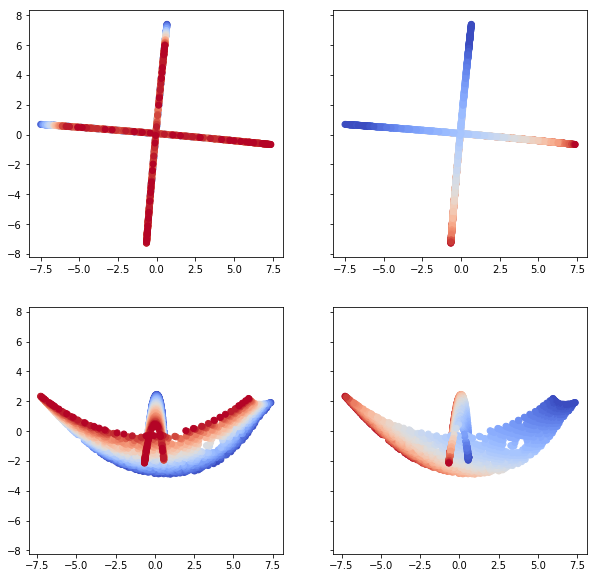

In [176]:
# GENERATE SYNTHETIC DATA (2 FREQUENCIES)

import tqdm
from sklearn.preprocessing import StandardScaler
n_alpha = 50
n_r = 50

min_alpha = 0.0
max_alpha = 4.0
min_r = -3.0
max_r = 1.0

r_range = np.linspace(min_r, max_r, n_r, endpoint=True)
alpha_range = np.linspace(min_alpha, max_alpha, n_alpha, endpoint=True)
N = 2**10
X = np.zeros((n_r, n_alpha, N))
for i, r in tqdm.tqdm(enumerate(r_range)):
    for j, a in enumerate(alpha_range):
        X[i, j, :], _ = generate(a, 2**r, f0=list(range(16, 18)), N=N)

# ISOMAP ON RAW WAVEFORM

from sklearn.manifold import Isomap

n_components = 3
n_neighbors = 40
raw_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
Xmat = X.reshape((n_r*n_alpha, N))
raw_iso = raw_isomap.fit_transform(Xmat)
raw_isoReshape = raw_iso.reshape((n_r, n_alpha, n_components))

alpha_tiled = np.tile(alpha_range, (n_r, 1));
r_tiled = np.tile(r_range, (n_alpha, 1)).T;

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=False, sharey=True)
axs = axs.flatten()

axs[0].scatter(
    np.ravel(raw_isoReshape[:, :, 0]),
    np.ravel(raw_isoReshape[:, :, 1]),
    c = np.ravel(r_tiled), cmap='coolwarm');
axs[1].scatter(
    np.ravel(raw_isoReshape[:, :, 0]),
    np.ravel(raw_isoReshape[:, :, 1]),
    c = np.ravel(alpha_tiled), cmap='coolwarm');
axs[2].scatter(
    np.ravel(raw_isoReshape[:, :, 1]),
    np.ravel(raw_isoReshape[:, :, 2]),
    c = np.ravel(r_tiled), cmap='coolwarm');
axs[3].scatter(
    np.ravel(raw_isoReshape[:, :, 1]),
    np.ravel(raw_isoReshape[:, :, 2]),
    c = np.ravel(alpha_tiled), cmap='coolwarm');


50it [00:02, 19.75it/s]


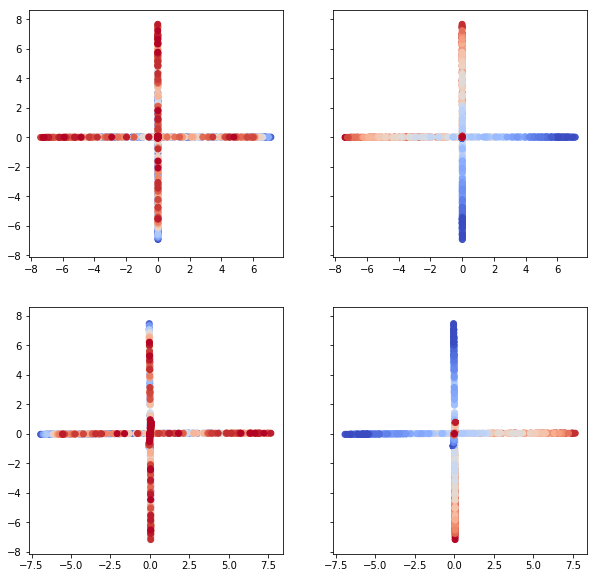

In [182]:
# GENERATE SYNTHETIC DATA (8 FREQUENCIES)

import tqdm
from sklearn.preprocessing import StandardScaler
n_alpha = 50
n_r = 50

min_alpha = 0.0
max_alpha = 4.0
min_r = -3.0
max_r = 1.0

r_range = np.linspace(min_r, max_r, n_r, endpoint=True)
alpha_range = np.linspace(min_alpha, max_alpha, n_alpha, endpoint=True)
N = 2**10
X = np.zeros((n_r, n_alpha, N))
frequencies = np.zeros((n_r, n_alpha))
for i, r in tqdm.tqdm(enumerate(r_range)):
    for j, a in enumerate(alpha_range):
        X[i, j, :], frequencies[i, j] = generate(a, 2**r, f0=list(range(12, 20)), N=N)

# ISOMAP ON RAW WAVEFORM

from sklearn.manifold import Isomap

n_components = 3
n_neighbors = 40
raw_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
Xmat = X.reshape((n_r*n_alpha, N))
raw_iso = raw_isomap.fit_transform(Xmat)
raw_isoReshape = raw_iso.reshape((n_r, n_alpha, n_components))

alpha_tiled = np.tile(alpha_range, (n_r, 1));
r_tiled = np.tile(r_range, (n_alpha, 1)).T;

fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=False, sharey=True)
axs = axs.flatten()

axs[0].scatter(
    np.ravel(raw_isoReshape[:, :, 0]),
    np.ravel(raw_isoReshape[:, :, 1]),
    c = np.ravel(r_tiled), cmap='coolwarm');
axs[1].scatter(
    np.ravel(raw_isoReshape[:, :, 0]),
    np.ravel(raw_isoReshape[:, :, 1]),
    c = np.ravel(alpha_tiled), cmap='coolwarm');
axs[2].scatter(
    np.ravel(raw_isoReshape[:, :, 1]),
    np.ravel(raw_isoReshape[:, :, 2]),
    c = np.ravel(r_tiled), cmap='coolwarm');
axs[3].scatter(
    np.ravel(raw_isoReshape[:, :, 1]),
    np.ravel(raw_isoReshape[:, :, 2]),
    c = np.ravel(alpha_tiled), cmap='coolwarm');


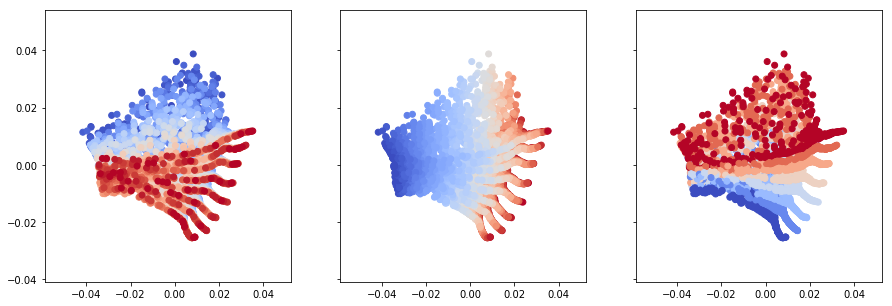

In [190]:
# SCATTERING WITH KYMATIO
scattering = kymatio.Scattering1D(J=int(np.log2(N)), Q=1, shape=(N,))
Xmat_torch = torch.from_numpy(Xmat).float()
Smat = np.maximum(0, scattering(Xmat_torch).numpy()[:, :, 0])

# ISOMAP ON SCATTERING TRANSFORM

from sklearn.manifold import Isomap

n_components = 3
n_neighbors = 40
sc_isomap = Isomap(n_neighbors=n_neighbors, n_components=n_components)
sc_iso = sc_isomap.fit_transform(Smat)
sc_isoReshape = sc_iso.reshape((n_r, n_alpha, n_components))

alpha_tiled = np.tile(alpha_range, (n_r, 1));
r_tiled = np.tile(r_range, (n_alpha, 1)).T;


fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=True)
axs = axs.flatten()

axs[0].scatter(
    np.ravel(sc_isoReshape[:, :, 0]),
    np.ravel(sc_isoReshape[:, :, 1]),
    c = np.ravel(r_tiled), cmap='coolwarm');
axs[1].scatter(
    np.ravel(sc_isoReshape[:, :, 0]),
    np.ravel(sc_isoReshape[:, :, 1]),
    c = np.ravel(alpha_tiled), cmap='coolwarm');
axs[2].scatter(
    np.ravel(sc_isoReshape[:, :, 0]),
    np.ravel(sc_isoReshape[:, :, 1]),
    c = np.ravel(frequencies), cmap='coolwarm');

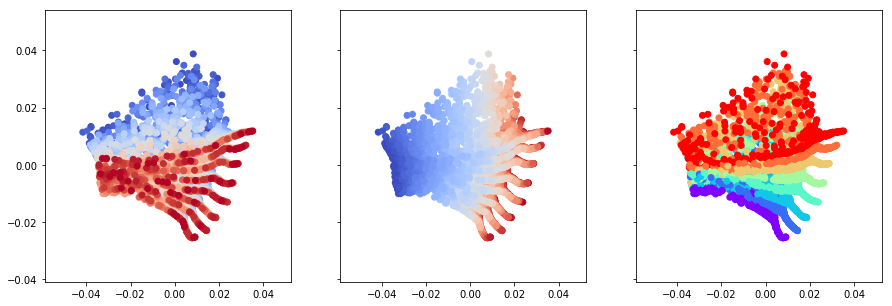

In [191]:

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=False, sharey=True)
axs = axs.flatten()

axs[0].scatter(
    np.ravel(sc_isoReshape[:, :, 0]),
    np.ravel(sc_isoReshape[:, :, 1]),
    c = np.ravel(r_tiled), cmap='coolwarm');
axs[1].scatter(
    np.ravel(sc_isoReshape[:, :, 0]),
    np.ravel(sc_isoReshape[:, :, 1]),
    c = np.ravel(alpha_tiled), cmap='coolwarm');
axs[2].scatter(
    np.ravel(sc_isoReshape[:, :, 0]),
    np.ravel(sc_isoReshape[:, :, 1]),
    c = np.ravel(frequencies), cmap='rainbow');